In [3]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

class MyTransform:
    def __init__(self):
        self.image_transform = transforms.Compose([
            transforms.Resize((256, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 512), interpolation=transforms.InterpolationMode.NEAREST)
        ])

    def __call__(self, image, mask):
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        mask = torch.tensor(np.array(mask), dtype=torch.long)  # Convert mask to tensor manually

        # Ensure mask values are within the range [0, num_classes-1]
        num_classes = 19
        mask = torch.clamp(mask, 0, num_classes - 1)
        return image, mask

class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = self._get_images()

    def _get_images(self):
        image_dir = os.path.join(self.root_dir, 'leftImg8bit', self.split)
        images = []
        for subdir, dirs, files in os.walk(image_dir):
            for file in files:
                if file.endswith("_leftImg8bit.png"):
                    images.append(os.path.join(subdir, file))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        base_dir = os.path.dirname(img_path)
        filename = os.path.basename(img_path)
        mask_filename = filename.replace('leftImg8bit', 'gtFine_labelIds')
        mask_path = os.path.join(base_dir.replace('leftImg8bit', 'gtFine'), mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Print unique values before transformation
        mask_np = np.array(mask)
        unique_values_before = np.unique(mask_np)
        print(f"Unique values in mask before transformation (index {index}): {unique_values_before}")

        if self.transform:
            image, mask = self.transform(image, mask)

        # Print unique values after transformation
        unique_values_after = torch.unique(mask)
        print(f"Unique values in mask after transformation (index {index}): {unique_values_after}")

        return image, mask

transform = MyTransform()

train_dataset = CityscapesDataset(
    root_dir='/home/maith/Desktop/cityscapes', 
    split='train', 
    transform=transform
)

val_dataset = CityscapesDataset(
    root_dir='/home/maith/Desktop/cityscapes', 
    split='val', 
    transform=transform
)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

Training samples: 2975
Validation samples: 500


In [4]:
# Initialize datasets with the custom transform
transform = MyTransform()

train_dataset = CityscapesDataset(
    root_dir='/home/maith/Desktop/cityscapes', 
    split='train', 
    transform=transform
)

val_dataset = CityscapesDataset(
    root_dir='/home/maith/Desktop/cityscapes', 
    split='val', 
    transform=transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 2975
Validation samples: 500


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super(PyramidPoolingModule, self).__init__()
        self.pools = [nn.AdaptiveAvgPool2d(output_size=size) for size in pool_sizes]
        self.conv_blocks = nn.ModuleList([nn.Conv2d(in_channels, 512, 1) for _ in pool_sizes])
        self.batch_norms = nn.ModuleList([nn.BatchNorm2d(512) for _ in pool_sizes])

    def forward(self, x):
        features = [x]
        for pool, conv, bn in zip(self.pools, self.conv_blocks, self.batch_norms):
            pooled = pool(x)
            convolved = conv(pooled)
            upsampled = F.interpolate(convolved, size=x.shape[2:], mode='bilinear', align_corners=False)
            features.append(bn(upsampled))
        return torch.cat(features, dim=1)

class CascadeFeatureFusion(nn.Module):
    def __init__(self, low_channels, high_channels, out_channels, num_classes):
        super(CascadeFeatureFusion, self).__init__()
        self.conv_low = nn.Conv2d(low_channels, out_channels, 3, padding=2, dilation=2)
        self.conv_high = nn.Conv2d(high_channels, out_channels, 1)
        self.conv_low_bn = nn.BatchNorm2d(out_channels)
        self.conv_high_bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.class_conv = nn.Conv2d(out_channels, num_classes, 1)

    def forward(self, low_res_input, high_res_input):
        low_res = self.relu(self.conv_low_bn(self.conv_low(low_res_input)))
        high_res = self.relu(self.conv_high_bn(self.conv_high(high_res_input)))
        
        # Resize high_res to match low_res spatial dimensions
        high_res = F.interpolate(high_res, size=low_res.shape[2:], mode='bilinear', align_corners=False)
        
        result = low_res + high_res
        class_output = self.class_conv(result)
        return result, class_output

class ICNet(nn.Module):
    def __init__(self, num_classes):
        super(ICNet, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove the last two layers (average pool and fc)
        self.ppm = PyramidPoolingModule(2048, [1, 2, 3, 6])
        self.cff1 = CascadeFeatureFusion(1024, 4096, 256, num_classes)  # Make sure channels match
        self.cff2 = CascadeFeatureFusion(512, 256, 128, num_classes)

    def forward(self, x):
        # Extract features at multiple levels
        layer1 = self.backbone[4](self.backbone[3](self.backbone[2](self.backbone[1](self.backbone[0](x)))))
        layer2 = self.backbone[5](layer1)
        layer3 = self.backbone[6](layer2)
        layer4 = self.backbone[7](layer3)

        # Apply Pyramid Pooling Module at the last layer output
        ppm_output = self.ppm(layer4)

        # Cascade Feature Fusion
        cff1_output, class_output1 = self.cff1(layer3, ppm_output)
        cff2_output, class_output2 = self.cff2(layer2, cff1_output)

        # Final classification layer
        final_output = F.interpolate(class_output2, scale_factor=4, mode='bilinear', align_corners=False)  # Scale up to input image size

        return final_output

model = ICNet(num_classes=19)  # Cityscapes has 19 classes

# Transfer the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/maith/Desktop/cityscapes/enet_cityscapes/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maith/Desktop/cityscapes/enet_cityscapes/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ICNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [6]:
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Loss Function
class_weights = torch.tensor([1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# using learning rate schedulers
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

from torch.utils.data import DataLoader

num_workers = 16

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=num_workers)

In [7]:
from tqdm import tqdm

def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, best_loss, early_stopping_counter):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch + 1}", leave=True)
    for batch_idx, (images, masks) in enumerate(progress_bar):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        masks = masks.squeeze(1).long()
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == masks).sum().item()
        total += masks.numel()

        progress_bar.set_postfix({'loss': running_loss / (batch_idx + 1), 'accuracy': 100 * correct / total})

    epoch_loss = running_loss / len(data_loader)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'model_best.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 5:
        print("Early stopping triggered.")
        return epoch_loss, 100 * correct / total, True

    return epoch_loss, 100 * correct / total, False

In [8]:
import numpy as np

def evaluate(model, criterion, data_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            # Squeeze the masks to remove the channel dimension
            masks = masks.squeeze(1).long()

            # Upsample outputs
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == masks).sum().item()
            total += masks.numel()

            all_preds.append(predicted.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy, np.concatenate(all_preds), np.concatenate(all_masks)

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(preds, masks, class_names):
    # Compute the confusion matrix with normalization
    cm = confusion_matrix(masks.flatten(), preds.flatten(), labels=range(len(class_names)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot for losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
best_loss = float('inf')
early_stopping_counter = 0
early_stopping_threshold = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy, early_stop_triggered = train_one_epoch(
        model, criterion, optimizer, train_loader, device, epoch, best_loss, early_stopping_counter
    )
    val_loss, val_accuracy, preds, masks = evaluate(model, criterion, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch + 1}/{num_epochs} completed. Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if early_stop_triggered:
        print("Early stopping was triggered due to no improvement in validation loss.")
        break

# Save the final model after training
torch.save(model.state_dict(), 'trained_icnet_model_final.pth')

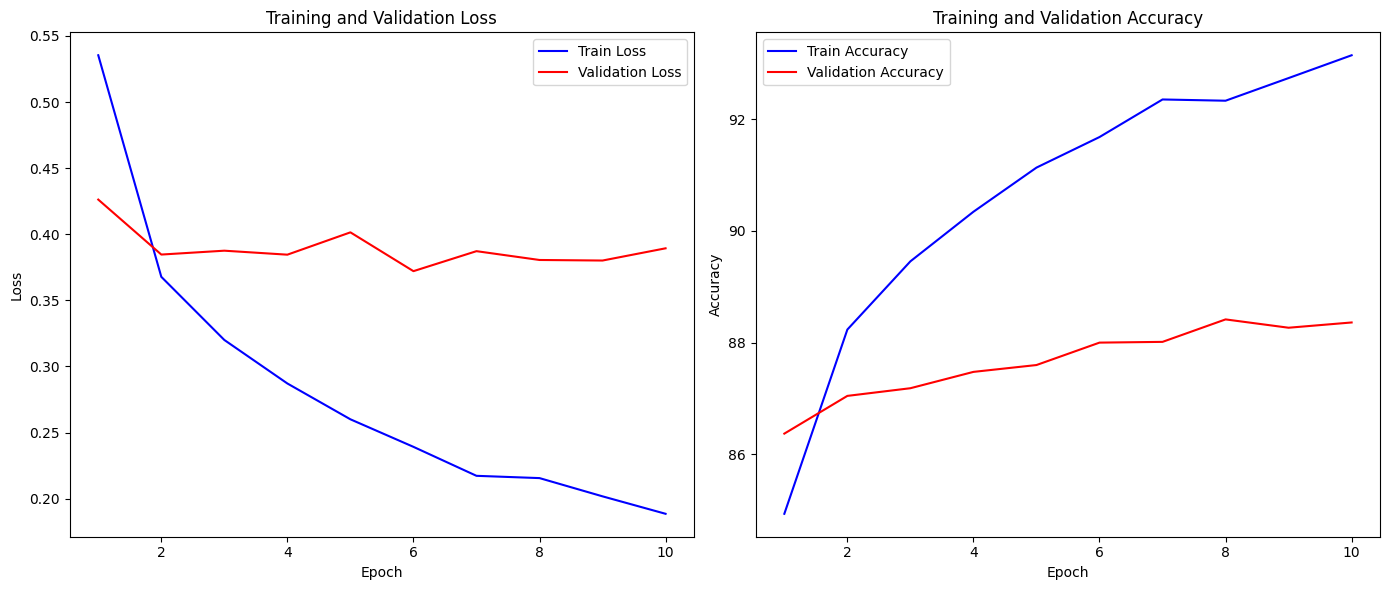

/tmp/ipykernel_263406/1320576905.py:8: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix


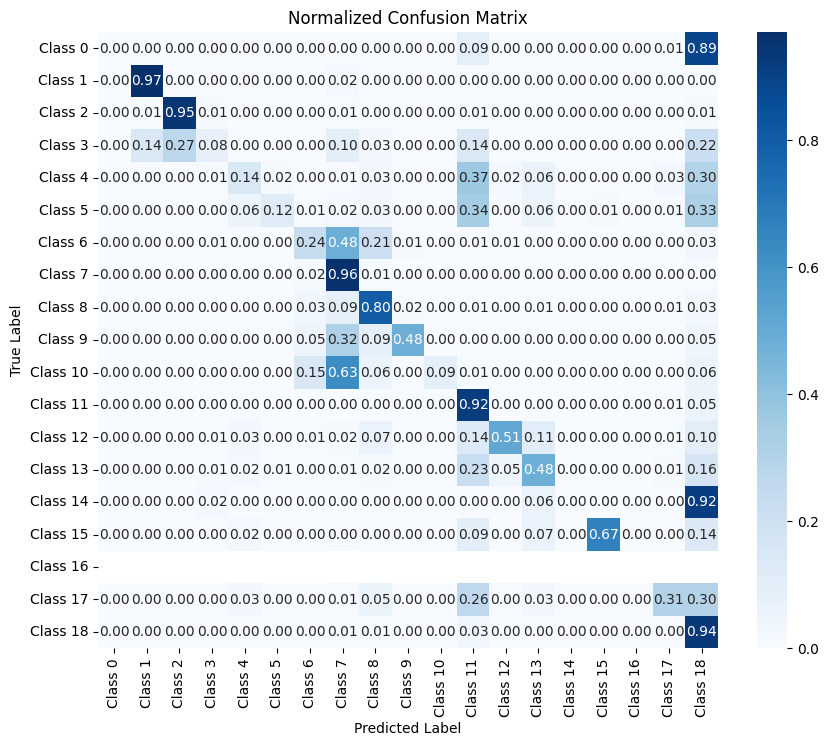

In [12]:
# Plot metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Plot confusion matrix
class_names = [f'Class {i}' for i in range(19)]
plot_confusion_matrix(preds, masks, class_names)

Unique values in mask before transformation (index 259): [ 1  2  3  4  5  7  8 11 12 17 19 20 21 23 26 27]
Unique values in mask before transformation (index 438): [ 1  3  4  5  7  8  9 11 12 13 17 20 21 22 23 24 26 32 33]Unique values in mask before transformation (index 161): [ 1  2  3  4  5  7  8 11 12 13 17 18 19 20 21 22 23 25 26 27 32 33]

Unique values in mask before transformation (index 475): [ 0  1  3  4  6 11 12 17 20 21 25 26 33]
Unique values in mask after transformation (index 438): tensor([ 1,  3,  4,  5,  7,  8,  9, 11, 12, 13, 17, 18])Unique values in mask after transformation (index 161): tensor([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 17, 18])Unique values in mask after transformation (index 259): tensor([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 17, 18])


Unique values in mask after transformation (index 475): tensor([ 0,  1,  3,  4,  6, 11, 12, 17, 18])
Unique values in mask before transformation (index 244): [ 1  2  3  4  6  7  8 11 17 19 20 21 23 24 25 26 33]
Unique v

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..1.9602616].


Unique values in mask after transformation (index 238): tensor([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 12, 13, 17, 18])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Unique values in mask before transformation (index 301): [ 1  3  4  5  7  8  9 11 12 17 20 21 23 24 25 26 33]
Unique values in mask before transformation (index 181): [ 1  2  3  4  5  6  7  8 11 13 17 19 20 21 23 24 26 32]Unique values in mask before transformation (index 83): [ 0  1  2  3  4  7  8 10 11 17 19 20 21 22 23 26 27 31]

Unique values in mask after transformation (index 301): tensor([ 1,  3,  4,  5,  7,  8,  9, 11, 12, 17, 18])
Unique values in mask after transformation (index 181): tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 13, 17, 18])Unique values in mask before transformation (index 358): [ 1  3  4  7  8 11 12 17 19 20 21 24 25 26 33]

Unique values in mask after transformation (index 83): tensor([ 0,  1,  2,  3,  4,  7,  8, 10, 11, 17, 18])
Unique values in mask after transformation (index 358): tensor([ 1,  3,  4,  7,  8, 11, 12, 17, 18])
Unique values in mask before transformation (index 274): [ 1  3  4  7  8  9 11 13 17 20 21 23 25 26 33]
Unique values in mask befo

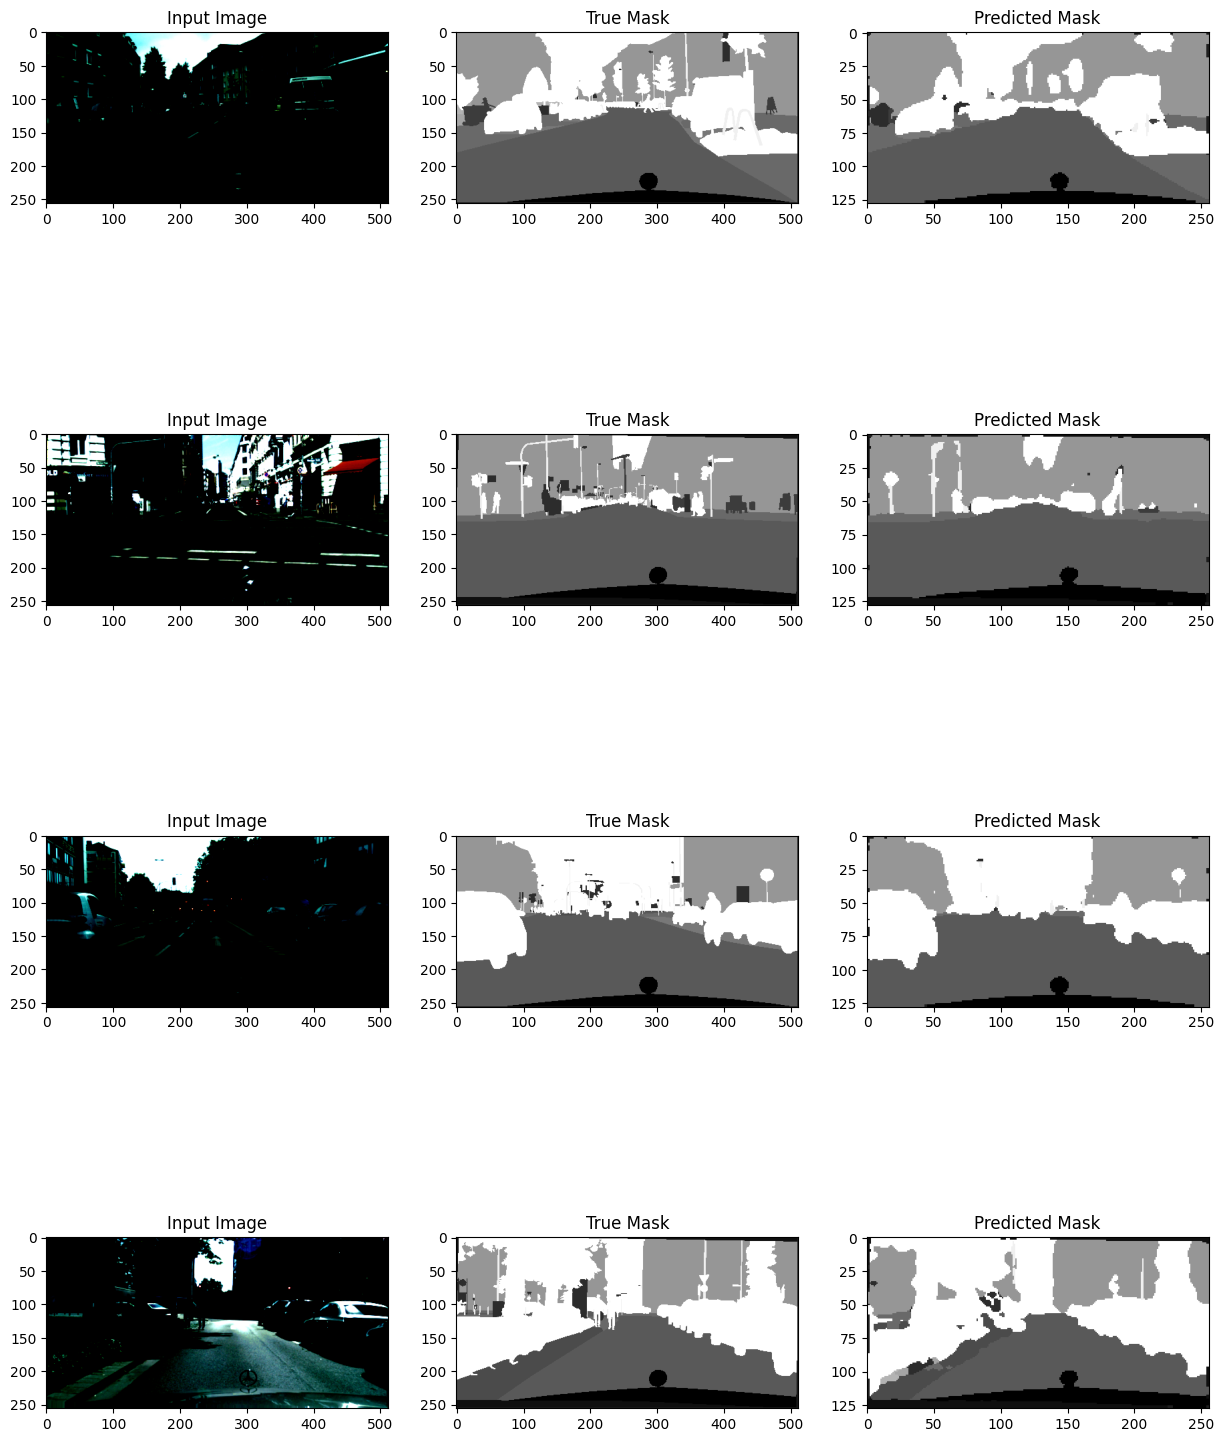

In [19]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def print_model_predictions(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)
            
            fig, axs = plt.subplots(len(images), 3, figsize=(15, len(images) * 5))
            for i in range(len(images)):
                axs[i, 0].imshow(images[i].cpu().permute(1, 2, 0).numpy())
                axs[i, 0].set_title("Input Image")
                axs[i, 1].imshow(masks[i].cpu().squeeze().numpy(), cmap='gray')
                axs[i, 1].set_title("True Mask")
                axs[i, 2].imshow(pred_masks[i].cpu().squeeze().numpy(), cmap='gray')
                axs[i, 2].set_title("Predicted Mask")
            plt.show()
            break

sample_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)
print_model_predictions(model, sample_loader, device)